<h1>Experiment 5.2. - Stepsizes adapt to problem parameters </h1>
<p>
    This file provides the code for recreating the experiment from Section 5.2. 
</p>
<p>
    <h3>Step 1:</h3>
    Definition of the problem setup and all necessary functions which change with the given problem.
</p>

In [1]:
# imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# following is used to make the labels in the plots nicer.
# probably have to use: pip install matplotlib-label-lines
from labellines import labelLines

In [2]:
# settings which determine the contect of the problem
n = 100
m = 200

nsqrt=10

steps = 1000

lambdas= [0.01, 0.1, 1.0, 10.0]

In [3]:
# in order to recreate the images from Figure 5.1 set the seed to 1
np.random.seed(42)

# creation of the problem setting
b = np.random.uniform(0.0, 1.0, n)

Dx = (np.eye(nsqrt)-np.eye(nsqrt+1)[1:,:-1])

D=np.block([[np.kron(np.eye(nsqrt),Dx)],
           [np.kron(Dx,np.eye(nsqrt))]])

# get some initial guesses
p_start = np.random.uniform(0.0, 10.0, n)
q_start = np.random.uniform(0.0, 10.0, m)

In [4]:
# objective function which is supposed to be minimized
def F(lamb, x):
    return 0.5*np.linalg.norm(x - b, 2)**2 + lamb * np.linalg.norm(D@x, 1)

In [5]:
# proximal mapping of f
def prox_f(x, t):
    return (x+t*b)/(1+t)

# proximal maping of the convex conjugate of g
def prox_g_c(y, s, lamb):
    return y - np.sign(y) * np.maximum(np.abs(y) - lamb, 0.0)

In [6]:
# matrices used in the following function
I_m = np.identity(m)
I_n = np.identity(n)

# compute resolvent of the matrix part of primal-dual DR
def matrix_resolvent(x, y, t, s):
    mat = np.block([[I_n, t * D.transpose()],
                    [-1.0 * s * D, I_m]])
    
    c = np.linalg.solve(mat, np.concatenate((x,y)))
    
    return c[:n], c[n:]

<p>
    <h3>Step 2:</h3>
    Definitions of the different stepsizes (stepsize methods) which should be used during the DR method later on
</p>

In [7]:
### define stepsize-methods which should be used later in the DR-algorithm
# all of them have to return values for both t and s.
# if only one stepsize t should vary, return t,t

# 'step' indicates the step in which we are in. 
# the functions will be called with step=-1 to get an initial stepsize before DR starts


# list methods to be considered in here. 
# structure is as follows: name/key of method, function callback, plot-type, plot-color

smallest_constant = -3
largest_constant = 3
num_of_constants = 8

constants = np.logspace(smallest_constant, largest_constant, num_of_constants)

# structure is as follows: name/key of method, function callback, plot-type, plot-color, line-width, line label
methods = []
for c1 in constants:
    for c2 in constants:
        methods.append([f'constant t = {c1, c2}',
        lambda p, q, x, y, t_before, s_before, step, c1=c1, c2=c2: (c1,c2),
        '-',
        'red',
        0.2,
        ''
        ])

# stepsize method for both t and s adaptive
def adaptive_ts(p, q, x, y, t_before, s_before, step):
    
    # initial stepsize
    if step == -1:
        return 1.0, 1.0
    
    #stepsize for all steps >= 0
    w = np.power(0.5, step)
    
    # if p=x then directly project, otherwise compute fraction and then project
    frac_t = 1e4
    if np.linalg.norm(p-x) > 1e-16:
        frac_t = np.linalg.norm(x)/np.linalg.norm(p-x)
        frac_t = max(min(frac_t, 1e04), 1e-04)
    
    t = (1.0 + w * frac_t - w) * t_before
    
    # the same for q=y
    frac_s = 1e4
    if np.linalg.norm(q-y)>1e-36:
        frac_s = np.linalg.norm(y)/np.linalg.norm(q-y)
        frac_s = max(min(frac_s, 1e04), 1e-04)
    s = (1.0 + w * frac_s - w) * s_before
    
    if t > 1e4:
        t = 1e4
    if s > 1e4:
        s = 1e4
    
    return t, s

methods.append(['$(t,s)$-adaptive', adaptive_ts, '-', 'blue', 1.5, 'adaptive'])

<p>
    <h3>Step 3:</h3>
    Execution of the DR method itself for all of the previously defined methods.
</p>

In [8]:
results = dict()

for lamb in lambdas:
    # dictionaries in which all of the results from the DR iteration for each lambda
    # will be stored for each method
    stepsizes_t = dict()
    stepsizes_s = dict()
    F_evals = dict()

    # apply DR for each of the methods listed above
    for method in methods:

        # store values in these lists
        stepsizes_t[method[0]] = []
        stepsizes_s[method[0]] = []
        F_evals[method[0]] = []

        # same starting point for each method
        p = p_start.copy()
        q = q_start.copy()

        x = np.zeros(n)
        y = np.zeros(m)

        # initial stepsizes
        t, s = method[1](p, q, x, y, 0, 0, -1)

        # start of DR method
        # loop through it more than necessary to get a better result for later comparison
        for step in range(3 * steps):
            x = prox_f(p, t)
            y = prox_g_c(q, s, lamb)

            u, v = matrix_resolvent(2.0 * x - p, 2.0 * y - q, t, s)

            # computation of new stepsizes
            t, s = method[1](p, q, x, y, t, s, step)
            
            #print(t,s)

            p = p + u - x
            q = q + v - y

            # store all values
            stepsizes_t[method[0]].append(t)
            stepsizes_s[method[0]].append(s)
            F_evals[method[0]].append(F(lamb, x))
        
    results[str(lamb)] = [F_evals, stepsizes_t, stepsizes_s]
    

<p>
    <h3>Step 4:</h3>
    Plot of the results from before.
</p>

λ=0.01 t=1.4515958496429766 s=0.05855294541360826


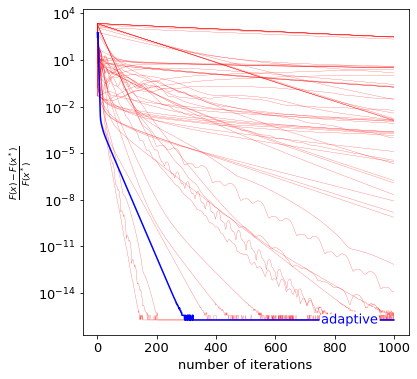

λ=0.1 t=1.3408993631353583 s=0.6827660281894526


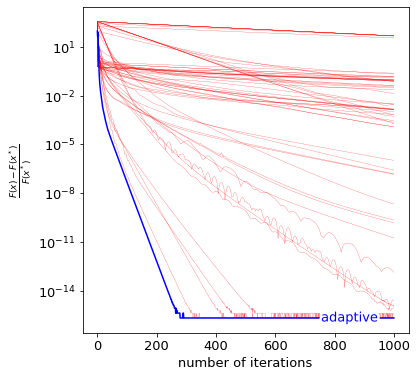

λ=1.0 t=1.3027620309099899 s=6.277414319989032


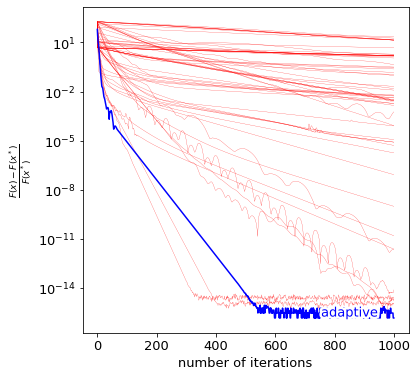

λ=10.0 t=1.0774839798687017 s=10000.0


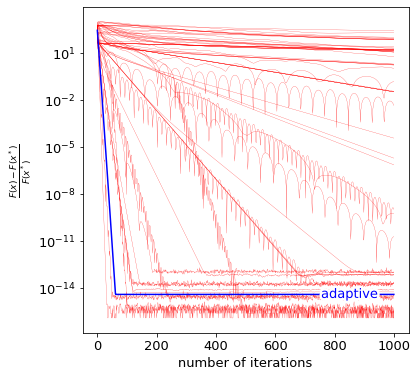

In [10]:
# modification of the decay values for plotting
def normalize_plot_values(vals, length, optimal):
    
    plot_vals = []
    
    for i in range(length):
        
        # if-condition prevents outbreaks of the graph to -inf in loglog plot
        if vals[i] != optimal:
            plot_vals.append(np.abs(vals[i] - optimal)/optimal)
        else:
            plot_vals.append(plot_vals[-1]) #the error is zero...
            
    return plot_vals

# set the text style
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

# one figure for each lambda
for lamb in lambdas:
    
    F_evals = results[str(lamb)][0]
    stepsizes_t = results[str(lamb)][1]
    stepsizes_s = results[str(lamb)][2]
    
    # print the (t,s)-stepsizes for each lambda once
    print("\u03BB="+str(lamb),
          "t="+str(stepsizes_t['$(t,s)$-adaptive'][-1]),
          "s=" + str(stepsizes_s['$(t,s)$-adaptive'][-1])
         )

    figure_F, ax_F = plt.subplots(1, figsize=(6, 6))

    # styling the box
    ax_F.set_box_aspect(1)
    ax_F.set(xlabel="number of iterations", ylabel=r"$\frac{F(x) - F(x^*)}{F(x^*)}$")

    # value which we assume to be optimal (after 3x of the considered iterations)
    optimal = min([F_evals[method[0]][-1] for method in methods])

    # plot the decay for each method with the styles defined before
    for method in methods:

        ax_F.semilogy(range(steps),
                    normalize_plot_values(F_evals[method[0]], steps, optimal),
                    linestyle = method[2],
                    color = method[3],
                    linewidth = method[4],
                    label = method[5]
                    )

    labelLines(plt.gca().get_lines(), zorder=2.5, xvals=850)
    # store and save everything
    plt.savefig(f"constant-vs-double-{lamb}.png", bbox_inches='tight', dpi=300)
    plt.show()
    